## **실습 내용**

** 목표** \\
딥 뉴럴 네트워크 기반 Resting-state fMRI 분석


1.   모델 구성
> * Auto-encoder
> * Stacked-auto-encoder
> * Sparse auto-encoder
> * L2 regularization  적용

2.  시각화
> * Auto-encoder의 input/ output  비교
> * ICA 와의 비교
 






## **Dataset**

### **Resting-state fMRI** 
ADNI (Alzheimer's Disease Neuroimaging Initiative) \\
ADNI2 dataset  -  eMCI (Mild Cognitive Impairment) & CN (Cognitive Normal) \\
http://adni.loni.usc.edu/ \\
31 early MCI (14F/ 17M) and 31 CN (17F/ 14M) \\
Repetition time = 3,000ms \\
Echo time = 30ms \\
Flip angle = 80 \\degree
qcquisition matrix size = 64 x 64, 48 slices \\
140 volumes \\
voxel thickness = 3.3mm \\

##** Preprocessing**
Magnetization equilibrium 을 위해 각 피험자의 데이터를 앞에서부터 10 volume 제거 \\
AAL template 이용하여 116 Regions Of Interest (ROIs)으로 parcellation \\
ROI intensity는 각 ROI에 포함되는 voxel들의 mean time-series \\
0.01~0.08 Hz 의 band-pass filter 적용 \\
각 피험자마다 ROI-wise Gaussian Normalization 적용 \\

**Subjects: 61, fMRI time scans: 130, ROIs: 116**

In [0]:
# Dataset download
!wget -nc -q https://github.com/wltjr1007/wltjr1007.github.io/raw/master/KHBM_ADNI_eMCINC_ERES.mat

## **Library Download**

In [0]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import sklearn
import sys
from IPython.display import Image, display

tf.set_random_seed(20180818)
np.random.seed(20180818)

In [3]:
# nilearn(Machine learning for Neuro-Imaging in Python) 라이브러리 다운로드 
# 시각화 함수 제공
# https://nilearn.github.io/index.html#

!pip install nilearn

In [4]:
# Tensorboard 설정
!rm -rf colab_utils
!git clone https://github.com/mixuala/colab_utils.git
import colab_utils.tboard as tboard
summ_path = "./log/"
ROOT=%pwd
tboard.launch_tensorboard(bin_dir=ROOT, log_dir=summ_path)

Cloning into 'colab_utils'...
remote: Counting objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 65.93 KiB | 7.33 MiB/s, done.
Resolving deltas: 100% (97/97), done.
ngrok installed
status: tensorboard=True, ngrok=True
tensorboard url= http://3a548e9d.ngrok.io


'http://3a548e9d.ngrok.io'

In [5]:
fMRI_data = scipy.io.loadmat("./KHBM_ADNI_eMCINC_ERES.mat")['Data']

print(fMRI_data.shape)
print('Subjects: %d, fMRI time scans: %d, ROIs: %d' % (fMRI_data.shape[0], fMRI_data.shape[1], fMRI_data.shape[2]))

# 학습을 위해 데이터 배열 변경 3D >> 2D 
# 하나의 fMRI scan이 하나의 샘플 데이터
ROISignals = fMRI_data.reshape(-1, fMRI_data.shape[-1]).copy()
print(ROISignals.shape)
print('Subjects*fMRI time scans: %d, ROIs: %d '% (ROISignals.shape[0], ROISignals.shape[1]))

(61, 130, 116)
Subjects: 61, fMRI time scans: 130, ROIs: 116
(7930, 116)
Subjects*fMRI time scans: 7930, ROIs: 116 


## **Auto-encoder** /  Stacked Auto-encoder

<img src="https://drive.google.com/uc?id=1kHnXqzXZzZc2vozHxCoUWCOWK0Qnk22Q" width="600" height="300">


**Encoder** \\



> $\textbf{h}^{(l)}$ =  $f$($W_{Encoder}^{(l)}$$\textbf{x}$+ $\textbf{b}_{Encoder}^{(l)}$) \\

, where 
> $D_{I}$ : number of ROIs  \\
>$D_{H}$: number of hidden units \\
> $l$ : $l$-th hidden layer \\
> $\textbf{x} \in \mathbb{R}^{D_{I}}$ : input data \\
> $ \textbf{W}_{Encoder} \in \mathbb{R}^{D_{H}\times D_{I}}$ \\
> $ \textbf{b}_{Encoder} \in \mathbb{R}^{D_{H}}$ \\
> $\textbf{h}^{(l)} \in \mathbb{R}^{D^{{(l)}}_{H}}$ : ouput of $l$-th layer hidden units after activation \\
> $f$ : activation function \\
>


**Decoder** \\


> $\hat{\textbf{x}}$ = $f$($W_{Decoder}^{(l+1)}\textbf{h}^{(l)}$+ $\textbf{b}_{Decoder}^{(l+1)}$) \\

, where
> $ \textbf{W}_{Decoder} \in \mathbb{R}^{D^{(l+1)}_{H}\times D_{H}^{(l)}}$ \\
> $ \textbf{b}_{Decoder} \in \mathbb{R}^{D^{(l+1)}_{H}}$ \\
> $\hat{\textbf{x}} \in \mathbb{R}^{D_{I}}$ : output data \\


**Cost Function** \\


> $J$ =$\frac{1}{2} $$\sum_{i=1}^{D_{I}}(\textbf{x}_{i} - \hat{\textbf{x}}_{i})^{2}$









In [0]:
## 학습 파라미터 설정
learning_rate = 0.01 
num_steps = 10
batch_size = 10
activation_function = 'sigmoid' # Other option: 'relu'
display_step = 1000

# 가중치 L2 regularization
l2_reg = False
lamda = tf.constant(0.001)

# Hidden unit activation sparsity
sparsity = True
rho = tf.constant(0.05)
beta = tf.constant(0.5)

## 데이터 입력
num_input = ROISignals.shape[1] # 입력값의 크기 =  ROI의 수 = 116
# shape = [batch (batch_size = 10), 입력값의 크기 (ROI의 수 = 116)]
# dtype = 데이터의 실수 표현(32 bit) 
X = tf.placeholder(shape=[None, num_input], dtype=tf.float32)

## 신경망 모델 구성
# Encoder 구성
encoder_arch = [num_input, 200] 
# encoder_arch = [num_input, 250, 250, 250] 
# Decoder 구성        
decoder_arch = [encoder_arch[-1], num_input]     
# decoder_arch = [encoder_arch[-1], 250, 250, num_input]     


weights_en = {}
biases_en = {}
weights_de = {}
biases_de = {}

# Encoder layer 와 Decoder layer 가중치 및 바이어스 초기화
for e in range(len(encoder_arch)-1):
  weights_en.update({'encoder_h%d'% (e+1) : tf.Variable(tf.random_normal([encoder_arch[e], encoder_arch[e+1]]))}) 
  biases_en.update({'encoder_b%d'% (e+1) : tf.Variable(tf.random_normal([encoder_arch[e+1]]))}) 
    
for d in range(len(decoder_arch)-1):
  weights_de.update({'decoder_h%d'% (d+1) : tf.Variable(tf.random_normal([decoder_arch[d], decoder_arch[d+1]]))}) 
  biases_de.update({'decoder_b%d'% (d+1) : tf.Variable(tf.random_normal([decoder_arch[d+1]]))}) 


In [0]:
# 인코더 레이어 구성
layer_en = {}
sparse_en = {}
def encoder(x, encoder_arch = encoder_arch, activeF= activation_function):   
    
    if activeF == 'sigmoid':
      for e in range(len(encoder_arch)-1):
        layer = tf.add(tf.matmul(layer_en['layer_en_%d'% (e)] if e != 0 else x, weights_en['encoder_h%d'% (e+1)]), biases_en['encoder_b%d' % (e+1)])
        sparse_en.update({'layer_en_%d' % (e+1): layer})
        layer = tf.nn.sigmoid(layer)
        layer_en.update({'layer_en_%d'%(e+1): layer})
    
    elif activeF == 'relu':
        for e in range(len(encoder_arch)-1):
          layer = tf.add(tf.matmul(layer_en['layer_en_%d'% (e)] if e != 0 else x, weights_en['encoder_h%d'% (e+1)]), biases_en['encoder_b%d' % (e+1)])
          sparse_en.update({'layer_en_%d' % (e+1): layer})
          layer = tf.nn.relu(layer)
          layer_en.update({'layer_en_%d'%(e+1): layer})
    
    return layer_en['layer_en_%d' % (len(encoder_arch)-1)]


In [0]:
# 디코더 레이어 구성
layer_de = {}
sparse_de = {}
def decoder(x, decoder_arch = decoder_arch, activeF= activation_function):
         
    if activeF == 'sigmoid':
      for d in range(len(decoder_arch)-1):
        layer = tf.add(tf.matmul(layer_de['layer_de_%d'% (d)] if d != 0 else x, weights_de['decoder_h%d'% (d+1)]), biases_de['decoder_b%d' % (d+1)])                  # 마지막 레이어의 경우 activation fucntion = identity

        # 마지막 레이어의 경우 activation fucntion = identity
        if d == (len(decoder_arch)-2):
          layer = tf.identity(layer)
          layer_de.update({'layer_de_%d'%(d+1): layer})
        else:
          sparse_de.update({'layer_de_%d' % (d+1): layer})
          layer = tf.nn.sigmoid(layer)
          layer_de.update({'layer_de_%d'%(d+1): layer})
        
    
    elif activeF == 'relu':
        for d in range(len(decoder_arch)-1):
          layer = tf.add(tf.matmul(layer_de['layer_de_%d'% (d)] if d != 0 else x, weights_de['decoder_h%d'% (d+1)]), biases_de['decoder_b%d' % (d+1)])
          
          # 마지막 레이어의 경우 activation fucntion = identity
          if d == (len(decoder_arch)-2):
            layer = tf.identity(layer)
            layer_de.update({'layer_de_%d'%(d+1): layer})
          else:
            sparse_de.update({'layer_de_%d' % (d+1): layer})
            layer = tf.nn.relu(layer)
            layer_de.update({'layer_de_%d'%(d+1): layer})
        

    return layer_de['layer_de_%d' % (len(decoder_arch)-1)]


In [0]:
## 신경망 모델

# 인코더
encoder_op = encoder(X, encoder_arch = encoder_arch, activeF = activation_function)
# 디코더
decoder_op = decoder(encoder_op, decoder_arch = decoder_arch, activeF = activation_function)


In [0]:
# 예측값: 디코더의 출력값
y_pred = decoder_op

# 실제값: 인코더의 입력값
y_true = X

## ** L2 Regularization & Sparse Auto-encoder Loss**
<img src="https://drive.google.com/uc?id=1zR2XhAJyWydFGatVlcevLZBBraXpzyzB" width="600" height="300">

,where
 > $D_{I}$ : number of ROIs  \\
>$D_{H}$: number of hidden units \\
> $\textbf{w}$: encoder or decoder weights \\
> $\textbf{x} \in \mathbb{R}^{D_{I}}$ : input data \\


<img src="https://drive.google.com/uc?id=1sz1Peijtgy7h67n0tAyjgCZ-5rgZPvSZ"  width="550" height="350">

,where
 > $D_{I}$ : number of ROIs  \\
>$D_{H}$: number of hidden units \\
> $\textbf{w}$: encoder or decoder weights \\
> $\textbf{x} \in \mathbb{R}^{D_{I}}$ : input data \\
> $KL$: KL-divergence \\
> $\rho$: sparsity parameter - hidden units의 평균 활성화 값 \\
>$\beta$: sparsity parameter - constraint 비율 조정 \\



In [0]:
# 손실값 설정
total_loss = tf.reduce_mean( tf.square(y_true-y_pred))

# Encoder/ Decoder의 가중치에 l2-regularization 적용
if l2_reg == True:
  
  encoder_l2_reg = []
  for e in range(len(encoder_arch)-1):
    encoder_l2_reg.append(tf.nn.l2_loss(weights_en['encoder_h%d' % (e+1)]))                          
  
  decoder_l2_reg = []
  for d in range(len(decoder_arch)-1):
    decoder_l2_reg.append(tf.nn.l2_loss(weights_de['decoder_h%d' % (d+1)]))
  
  total_l2loss_en = np.sum(encoder_l2_reg)
  total_l2loss_de = np.sum(decoder_l2_reg)
                          
                          
  total_l2_loss = lamda*(total_l2loss_en + total_l2loss_de)
  total_loss  = total_loss + total_l2_loss 

# hidden layer unit activation에 대한 sparsity 적용
if sparsity == True:
  
  def kl_divergence(rho, rho_hat):
      return rho * tf.log(rho) - rho * tf.log(rho_hat) + (1 - rho) * tf.log(1 - rho) - (1 - rho) * tf.log(1 - rho_hat)
  
  # 각 Hidden layer에서의 sparsity 적용
  kl_en = []
  kl_de = []
  for e in range(1, len(encoder_arch)):
    rho_hat_en = tf.reduce_mean(layer_en['layer_en_%d'% (e)], axis=0)
    kl_en.append(beta*(tf.reduce_sum(kl_divergence(rho, rho_hat_en))))
  print(kl_en)
  
  for d in range(len(decoder_arch)-2):
    rho_hat_de = tf.reduce_mean(layer_de['layer_de_%d'% (d+1)], axis=0)
    kl_de.append(beta*(tf.reduce_sum(kl_divergence(rho, rho_hat_de))))
  print(kl_de)

  total_sparse_en = tf.reduce_sum(kl_en)
  print(total_sparse_en.get_shape)
  total_sparse_de = tf.reduce_sum(kl_de)
  sparsity_loss = total_sparse_en + total_sparse_de
  print(sparsity_loss.get_shape)
  
  total_loss = total_loss + sparsity_loss

# loss 값의 변화를 tensorboard 에 기록
tf.summary.scalar( 'Loss', total_loss ) 

# 최적화 함수 - 손실값 최소화
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(total_loss)

[<tf.Tensor 'mul_4:0' shape=() dtype=float32>]
[]
<bound method Tensor.get_shape of <tf.Tensor 'Sum_1:0' shape=() dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'add_3:0' shape=() dtype=float32>>


In [0]:
# 텐서보드 변수 요약 함수
summary_op =  tf.summary.merge_all()

# 모든 변수 초기화 함수
init = tf.global_variables_initializer()

In [0]:
## 신경망 모델 학습

# tensorflow session 선언
sess = tf.Session()

# 모든 변수 초기화
sess.run( init )

# 텐서보드 
train_writer = tf.summary.FileWriter( summ_path, sess.graph )
# 모델 저장 함수
saver = tf.train.Saver()

# 신경망 모델 배치 단위 학습 
randidx = np.random.permutation( np.arange(ROISignals.shape[0], dtype=np.uint32) ) # ROISignals.shape[0] = 데이터 샘플 수 
cur_epoch = 0

for i in range(num_steps*ROISignals.shape[0]//batch_size): 
    offset = i%(ROISignals.shape[0]//batch_size)
    # 배치 설정 
    batch_x = ROISignals[randidx[offset*batch_size:(offset+1)*batch_size]].copy()

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l, l_tsb = sess.run( [optimizer, total_loss, summary_op], feed_dict={X: batch_x} )
    
    # Epoch이 끝날 때마다 데이터 셔플
    if cur_epoch != int((i*batch_size)/ROISignals.shape[0]): 
      randidx = np.random.permutation(ROISignals.shape[0])
    cur_epoch = int((i*batch_size)/ ROISignals.shape[0])
    
    # 표기
    if i%display_step == 0 or i == 1:
      train_writer.add_summary(l_tsb, i)
      print('Step %i: Minibatch Loss: %f' % (i, l))

# 모델 저장
saver.save( sess, summ_path+'saved_model.ckpt' )


Step 0: Minibatch Loss: 157.186584
Step 1: Minibatch Loss: 148.792511
Step 1000: Minibatch Loss: 5.469630
Step 2000: Minibatch Loss: 2.074626
Step 3000: Minibatch Loss: 1.813513
Step 4000: Minibatch Loss: 1.262905
Step 5000: Minibatch Loss: 1.103261
Step 6000: Minibatch Loss: 0.882067
Step 7000: Minibatch Loss: 0.865690


'./log/saved_model.ckpt'

In [0]:
# 모든 변수 초기화
sess.run( init )

# 모델 저장 함수 & 불러오기
saver.restore(sess, summ_path + 'saved_model.ckpt')

subject_num = 2
output = sess.run(decoder_op, {X: fMRI_data[subject_num-1,:, :]})
# encoder_output = sess.run(encoder_op, {X: fMRI_data[subject_num-1,:, :]})

INFO:tensorflow:Restoring parameters from ./log/saved_model.ckpt


## **Visualization**

In [0]:
# 시각화: 입력값과 출력값 fMRI 비교
from nilearn import datasets
from nilearn import plotting
from nilearn import regions

# AAL 116 Atlas 다운로드 
atlas_data = datasets.fetch_atlas_aal(version='SPM12', verbose=1)
atlas_filename= atlas_data.maps



/usr/local/lib/python3.6/dist-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_e


Dataset created in /content/nilearn_data/aal_SPM12



Downloaded 351343 of 351343 bytes (100.0%,    0.0s remaining) ...done. (10 seconds, 0 min)
Extracting data from /content/nilearn_data/aal_SPM12/a2fc9a441ebe10d638e4a74b1d3c1dac/aal_for_SPM12.tar.gz..... done.


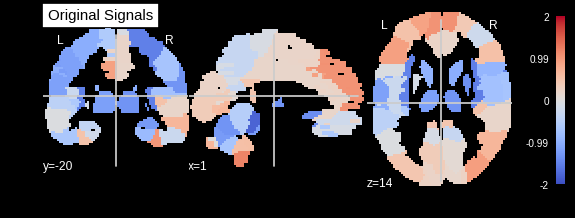

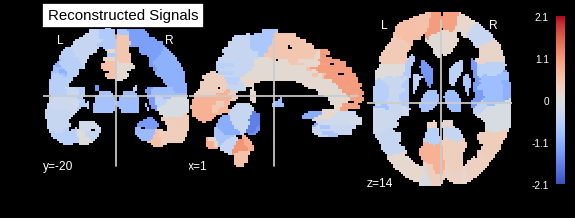

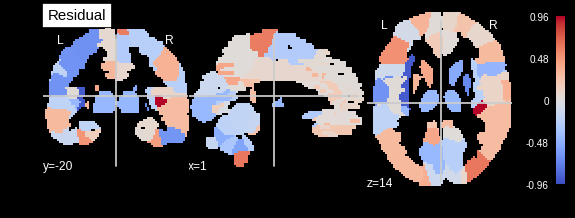

In [0]:
timescan = 20
# 입력값
# regions.signals_to_img_labels: 116 ROI 신호를 기존의 voxel 단위의 신호로 재구성
# signals = [fMRI time scan 수, ROI의 수]
# labels_img = AAL atlas, AAL atlas 의 116개의 라벨을 이용하여 signal 재구성
# mask_img = None, mask 에 해당하는 ROI만 함수를 실행하는 함수, 여기서는 116 ROI 전체에 적용할 것이기 때문에 None 으로 설정
# background_label = 0, 신호가 없는 부분은 intensity 0으로 처리
mkmaps_origin = regions.signals_to_img_labels(signals=fMRI_data[subject_num-1,:, :], labels_img = atlas_filename, mask_img=None, background_label=0, order='F' )
# 130개의 time scan 중 slice 선택
mkmaps_origin = mkmaps_origin.slicer[:, :, :, timescan]
# 시각화 함수
# stat_map_img: 시각화 하고자 하는 fMRI 신호 입력
# bg_img  = AAL atals, AAL atlas에 stat_map_img를 시각화
# cut_coords = x y z coordinates
plotBrain_origin = plotting.plot_stat_map(stat_map_img=mkmaps_origin, bg_img=atlas_filename, colorbar=True, cut_coords = [1, -20, 14], cmap= 'coolwarm', title='Original Signals' )
plotting.show()

# 출력값
mkmaps_recon = regions.signals_to_img_labels(output, atlas_filename, mask_img = None, background_label=0, order='F')
mkmaps_recon = mkmaps_recon.slicer[:, :, :, timescan]
plotBrain_recon = plotting.plot_stat_map(mkmaps_recon, atlas_filename, colorbar=True, cut_coords = [1, -20, 14], cmap= 'coolwarm', title='Reconstructed Signals' )
plotting.show()

# Residual
residual = fMRI_data[subject_num-1,:, :] - output 
mkmaps_recon = regions.signals_to_img_labels(residual, atlas_filename, mask_img = None, background_label=0, order='F')
mkmaps_recon = mkmaps_recon.slicer[:, :, :, timescan]
plotBrain_recon = plotting.plot_stat_map(mkmaps_recon, atlas_filename, colorbar=True, cut_coords = [1, -20, 14], cmap= 'coolwarm', title='Residual' )
plotting.show()

## **ICA**

**ICA 와 Auto-encoder 의 비교**
## <img src="https://drive.google.com/uc?id=1kTdgySPkTNFGPZ38dBSGmkLJqtm3ohL1" width = "750" height= "400"> 



In [0]:
## ICA

from sklearn.decomposition import FastICA

# ICA component 수 설정
n_components = 20

# ICA 함수 실행 
# 입력값 ( 7920 samples, 116 features)

ica = FastICA( n_components=n_components, random_state=42 )
components_masked = ica.fit_transform(ROISignals).T 
# (sample 수, ICA component 수)
print( components_masked.shape )

mixing_matrix = ica.mixing_
print( mixing_matrix.shape )

# Normalize estimated components, for thresholding to make sense
components_masked -= components_masked.mean(axis=0)
components_masked /= components_masked.std(axis=0)

# Threshold
components_masked[np.abs(components_masked)<.8] = 0

# Now invert the masking operation, going back to a full 3D
# representation
# component_img = masker.inverse_transform(components_masked)


(20, 7930)
(116, 20)


In [0]:
component = 11 # Set an index of the component of your interest
print('ICA component %d' % component)

mixing_matrix = mixing_matrix.T

# Normalize estimated components, for thresholding to make sense
mixing_matrix -= mixing_matrix.mean(axis=0)
mixing_matrix /= mixing_matrix.std(axis=0)

# Thresholding
# mixing_matrix[np.abs(mixing_matrix) < .9] = 0
mixing_matrix[np.abs(mixing_matrix) < (mixing_matrix.mean(axis=0)+2.0*(mixing_matrix.std(axis=0)))] = 0

mkmaps_ica = regions.signals_to_img_labels(mixing_matrix, atlas_filename, mask_img = None, background_label=0, order='F')

mkmaps_ica = mkmaps_ica.slicer[:, :, :, component-1]

plotBrain_ica = plotting.plot_stat_map(mkmaps_ica, atlas_filename, colorbar=True)
plotting.show()



ICA component 11


IndexError: ignored

In [0]:
## Auto-encoder 

# 모든 변수 초기화
sess.run(init)

# 모델 저장 함수 & 불러오기
saver.restore(sess, summ_path + 'saved_model.ckpt')

weights_dict = sess.run(weights_de)
AE_mixing_matrix = weights_dict['decoder_h%d' % (len(decoder_arch)-1)]

INFO:tensorflow:Restoring parameters from ./log/saved_model.ckpt


In [0]:

AE_component = 15 #Please choose the component
print('Autoencoder weights component %d' % component)

# Normalize estimated components, for thresholding to make sense
AE_mixing_matrix -= AE_mixing_matrix.mean(axis=0)
AE_mixing_matrix /= AE_mixing_matrix.std(axis=0)

# Thresholding
AE_mixing_matrix[np.abs(AE_mixing_matrix) < .9] = 0

mkmaps_AE = regions.signals_to_img_labels(AE_mixing_matrix, atlas_filename, mask_img = None, background_label=0, order='F')
mkmaps_AE = mkmaps_AE.slicer[:,:,:, AE_component-1]

plotBrain_ae = plotting.plot_stat_map(mkmaps_AE, atlas_filename, colorbar=True)
plotting.show()


NameError: ignored